Загружаем библиотеки:

In [260]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
from keras import models, layers
import keras
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout

Загружаем данные и оформляем их в виде таблицы:

In [261]:
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Добавим таргет:

In [262]:
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Проводим первоначальный анализ данных:

In [263]:
print("В данных {} столбцов и {} строк". format(df.shape[0], df.shape[1]))

В данных 506 столбцов и 14 строк


In [264]:
df.nunique()

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
MEDV       229
dtype: int64

CHAS и RAD можно обозначить как категориальные.

In [265]:
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

In [266]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Невообруженным взглядом видно выбросы у CRIM и ZN. Их среднее значение сильно отличается от максимального значения, поэтому обязательно проверим данные на выбросы. Воспользуемся графиком BoxPlot:

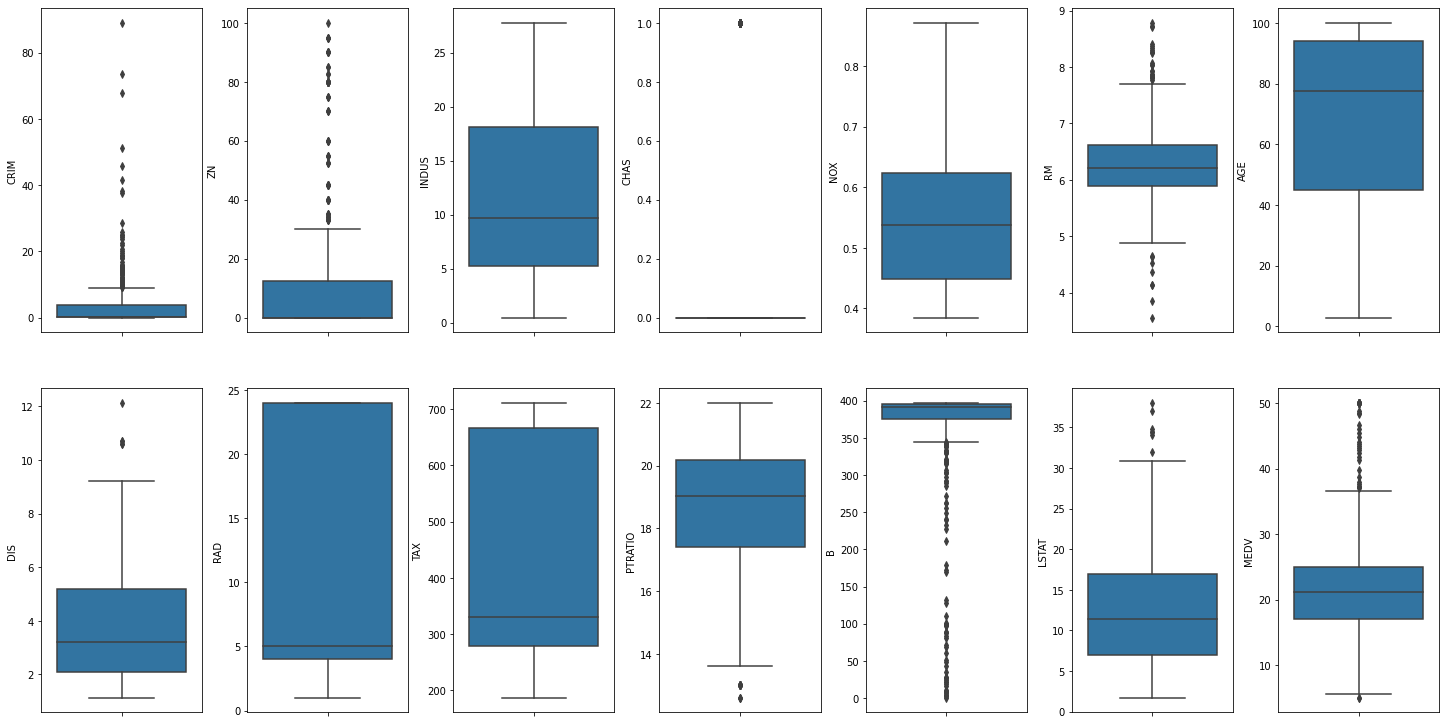

In [267]:

fig, ax = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
ax = ax.flatten()
for k,v in df.items():
    sns.boxplot(y=k, data=df, ax=ax[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Колонки CRIM, ZN, RM, B имеют много выбросов. Проверим процент выбросов во всех колонках:

In [268]:
for k, v in df.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column CRIM outliers = 13.04%
Column ZN outliers = 13.44%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 1.38%
Column MEDV outliers = 7.91%


Разберемся с выбросами через IQR:

In [269]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

CRIM         3.595038
ZN          12.500000
INDUS       12.910000
CHAS         0.000000
NOX          0.175000
RM           0.738000
AGE         49.050000
DIS          3.088250
RAD         20.000000
TAX        387.000000
PTRATIO      2.800000
B           20.847500
LSTAT       10.005000
MEDV         7.975000
dtype: float64


Данные без выбросов запишешь в отдельную переменную, чтобы оценить в дальнейшем точность данных с выбросами и без них:

In [270]:
df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df_out.shape

(268, 14)

Взглянем на корреляционную матрицу:

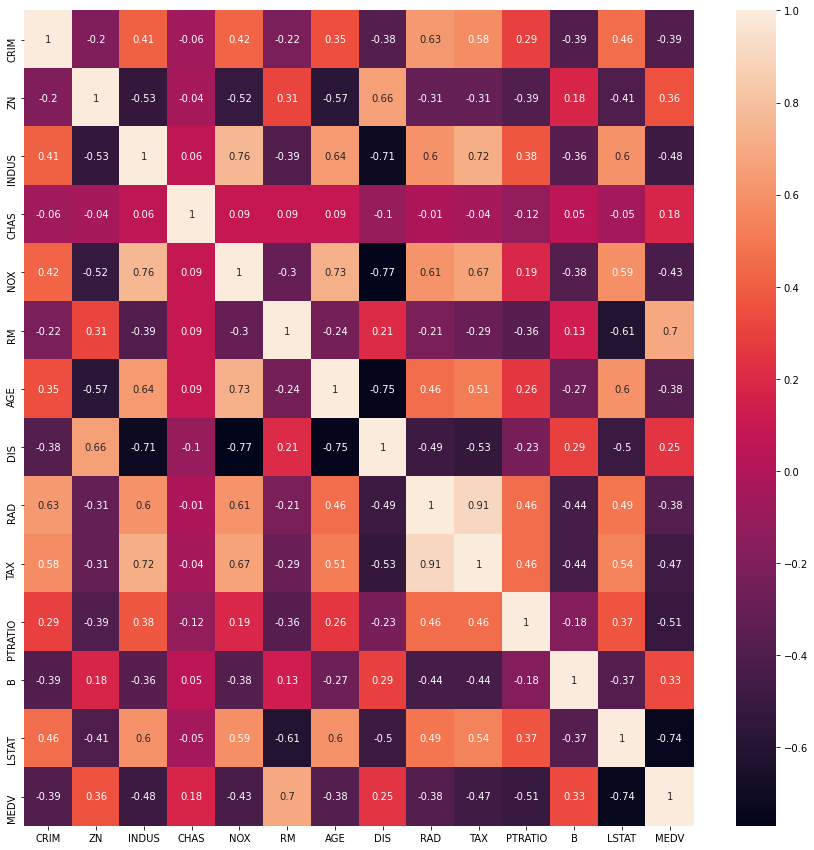

In [271]:
correlation_matrix = df.corr().round(2)
plt.figure(figsize = (15,15))
sns.heatmap(data=correlation_matrix, annot=True)

In [272]:
cols = list(df.columns)

for col in cols: 
    pearson_coef, p_value = stats.pearsonr(df[col], df['MEDV'])
    print("PearsonR между {} и MEDV {} с P-знчением P = {}".format(
          col, pearson_coef, p_value ))
    
    if p_value < 0.001:
        print('Корреляция между {} и MEDV статистически значимая'.format(col))
    elif p_value < 0.05:
        print('Корреляция между {} и MEDV средняя'.format(col))
    elif p_value < 0.1:
        print('Корреляция между {} и MEDV слабая'.format(col))
    else:
        print('Корреляция между {} и MEDV статистически незначимая'.format(col))
        
    if pearson_coef > 0 :
        if pearson_coef > 0.85:
            print('Коэффициент ~{} показывает положительную очень сильную связь\n'.format(pearson_coef))
        elif pearson_coef > 0.75 :
            print('Коэффициент ~{} показывает положительную достаточно сильную связь\n'.format(pearson_coef))
        elif pearson_coef > 0.60:
            print('Коэффициент ~{} показывает положительную относительно сильную связь\n'.format(pearson_coef))
        elif pearson_coef > 0.50 :
            print('Коэффициент ~{} показывает положительную среднюю связь\n'.format(pearson_coef))
        else:
            print('Коэффициент ~{} показывает положительную слабую связь\n'.format(pearson_coef))
    else:
        if abs(pearson_coef) > 0.85:
            print('Коэффициент ~{} показывает негативную очень сильную связь\n'.format(pearson_coef))
        elif abs(pearson_coef) > 0.75 :
            print('Коэффициент ~{} показывает негативную достаточно сильную связь\n'.format(pearson_coef))
        elif abs(pearson_coef) > 0.60:
            print('Коэффициент ~{} показывает негативную относительно сильную связь\n'.format(pearson_coef))
        elif abs(pearson_coef) > 0.50 :
            print('Коэффициент ~{} показывает положительную среднюю связь\n'.format(pearson_coef))
        else:
            print('Коэффициент ~{} показывает положительную слабую связь\n'.format(pearson_coef))

PearsonR между CRIM и MEDV -0.38830460858681154 с P-знчением P = 1.1739870821941207e-19
Корреляция между CRIM и MEDV статистически значимая
Коэффициент ~-0.38830460858681154 показывает положительную слабую связь

PearsonR между ZN и MEDV 0.36044534245054316 с P-знчением P = 5.713584153079442e-17
Корреляция между ZN и MEDV статистически значимая
Коэффициент ~0.36044534245054316 показывает положительную слабую связь

PearsonR между INDUS и MEDV -0.483725160028373 с P-знчением P = 4.900259981751351e-31
Корреляция между INDUS и MEDV статистически значимая
Коэффициент ~-0.483725160028373 показывает положительную слабую связь

PearsonR между CHAS и MEDV 0.1752601771902984 с P-знчением P = 7.39062317051802e-05
Корреляция между CHAS и MEDV статистически значимая
Коэффициент ~0.1752601771902984 показывает положительную слабую связь

PearsonR между NOX и MEDV -0.42732077237328253 с P-знчением P = 7.065041586251507e-24
Корреляция между NOX и MEDV статистически значимая
Коэффициент ~-0.42732077237

Все связи статистически значимы, поэтому ничего убирать не будем.

Оформим категориальные переменные:

In [273]:
for col in df.columns:
    if df[col].nunique() <= 10:
        df[col] = df[col].astype("category")

In [274]:
df.dtypes

CRIM        float64
ZN          float64
INDUS       float64
CHAS       category
NOX         float64
RM          float64
AGE         float64
DIS         float64
RAD        category
TAX         float64
PTRATIO     float64
B           float64
LSTAT       float64
MEDV        float64
dtype: object

In [275]:
df = pd.get_dummies(df)

Оформляем данные для модели: шкалируем, разбивает на тренировочную и тестовую выборки

In [276]:
X = df.drop('MEDV', axis = 1)
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Строим и тестируем модели:

In [277]:
# линейная регрессия
model1 = LinearRegression()

# градиентный бустинг
model2 = LGBMRegressor(max_depth=4, n_estimators=300, learning_rate=0.005, random_state=1)
model3 = LGBMRegressor(max_depth=6, n_estimators=300, learning_rate=0.005, random_state=1)

# случайный лес
model4 = RandomForestRegressor(n_estimators=10, random_state=1)
model5 = RandomForestRegressor(n_estimators=15, random_state=1)

# обычный бэггинг линейныйх регрессий
model6 = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=10, random_state=1)
model7 = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=15, random_state=1)

# обычный бэггинг деревьев
model8 = BaggingRegressor(n_estimators=10, random_state=1)
model9 = BaggingRegressor(n_estimators=15, random_state=1)

models = [model1, model2, model3, model4, model5,
         model6, model7, model8, model9]

table_models = pd.DataFrame(columns = ["mean_absolute_error"], index = ["model "+str(i) for i in range(1,10)])

In [278]:
for num, mod in tqdm(enumerate(models)):
    mod.fit(X_train_scaled, y_train)
    mae_valid = mean_absolute_error(y_test, mod.predict(X_test_scaled))
    table_models.loc["model "+str(num+1), "mean_absolute_error"] = mae_valid

9it [00:00, 27.87it/s]


In [279]:
table_models.sort_values(by="mean_absolute_error")

,mean_absolute_error
model 5,2.42217
model 4,2.46034
model 9,2.46358
model 8,2.55714
model 3,3.13106
model 2,3.15832
model 7,3.62848
model 1,3.63387
model 6,3.65657


Мы видим, что Random Forest показывает наилучший результат. Поэтому стоит акцентировать внимание именно на этой модели и улучшить ее параметры через GridSearch.

Но одно мы забыли сделать, а именно отобрать признаки, учитывая то, что мы добавили несколько новых из-за их категориальности.

In [280]:
cols = list(df.columns)

for col in cols: 
    pearson_coef, p_value = stats.pearsonr(df[col], df['MEDV'])
    print("PearsonR между {} и MEDV {} с P-знчением P = {}".format(
          col, pearson_coef, p_value ))
    
    if p_value < 0.001:
        print('Корреляция между {} и MEDV статистически значимая'.format(col))
    elif p_value < 0.05:
        print('Корреляция между {} и MEDV средняя'.format(col))
    elif p_value < 0.1:
        print('Корреляция между {} и MEDV слабая'.format(col))
    else:
        print('Корреляция между {} и MEDV статистически незначимая'.format(col))
        
    if pearson_coef > 0 :
        if pearson_coef > 0.85:
            print('Коэффициент ~{} показывает положительную очень сильную связь\n'.format(pearson_coef))
        elif pearson_coef > 0.75 :
            print('Коэффициент ~{} показывает положительную достаточно сильную связь\n'.format(pearson_coef))
        elif pearson_coef > 0.60:
            print('Коэффициент ~{} показывает положительную относительно сильную связь\n'.format(pearson_coef))
        elif pearson_coef > 0.50 :
            print('Коэффициент ~{} показывает положительную среднюю связь\n'.format(pearson_coef))
        else:
            print('Коэффициент ~{} показывает положительную слабую связь\n'.format(pearson_coef))
    else:
        if abs(pearson_coef) > 0.85:
            print('Коэффициент ~{} показывает негативную очень сильную связь\n'.format(pearson_coef))
        elif abs(pearson_coef) > 0.75 :
            print('Коэффициент ~{} показывает негативную достаточно сильную связь\n'.format(pearson_coef))
        elif abs(pearson_coef) > 0.60:
            print('Коэффициент ~{} показывает негативную относительно сильную связь\n'.format(pearson_coef))
        elif abs(pearson_coef) > 0.50 :
            print('Коэффициент ~{} показывает положительную среднюю связь\n'.format(pearson_coef))
        else:
            print('Коэффициент ~{} показывает положительную слабую связь\n'.format(pearson_coef))

PearsonR между CRIM и MEDV -0.38830460858681154 с P-знчением P = 1.1739870821941207e-19
Корреляция между CRIM и MEDV статистически значимая
Коэффициент ~-0.38830460858681154 показывает положительную слабую связь

PearsonR между ZN и MEDV 0.36044534245054316 с P-знчением P = 5.713584153079442e-17
Корреляция между ZN и MEDV статистически значимая
Коэффициент ~0.36044534245054316 показывает положительную слабую связь

PearsonR между INDUS и MEDV -0.483725160028373 с P-знчением P = 4.900259981751351e-31
Корреляция между INDUS и MEDV статистически значимая
Коэффициент ~-0.483725160028373 показывает положительную слабую связь

PearsonR между NOX и MEDV -0.42732077237328253 с P-знчением P = 7.065041586251507e-24
Корреляция между NOX и MEDV статистически значимая
Коэффициент ~-0.42732077237328253 показывает положительную слабую связь

PearsonR между RM и MEDV 0.6953599470715394 с P-знчением P = 2.4872288710071593e-74
Корреляция между RM и MEDV статистически значимая
Коэффициент ~0.695359947071

Три колонки статистически незначимые, удалим их.

In [281]:
df.drop(['RAD_6.0', 'RAD_4.0', 'RAD_1.0'], axis = 1, inplace = True)

Протестируем все снова:

In [282]:
#Обработка данных
X = df.drop('MEDV', axis = 1)
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# линейная регрессия
model1 = LinearRegression()

# градиентный бустинг
model2 = LGBMRegressor(max_depth=4, n_estimators=300, learning_rate=0.005, random_state=1)
model3 = LGBMRegressor(max_depth=6, n_estimators=300, learning_rate=0.005, random_state=1)

# случайный лес
model4 = RandomForestRegressor(n_estimators=10, random_state=1)
model5 = RandomForestRegressor(n_estimators=15, random_state=1)

# обычный бэггинг линейныйх регрессий
model6 = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=10, random_state=1)
model7 = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=15, random_state=1)

# обычный бэггинг деревьев
model8 = BaggingRegressor(n_estimators=10, random_state=1)
model9 = BaggingRegressor(n_estimators=15, random_state=1)

models = [model1, model2, model3, model4, model5,
         model6, model7, model8, model9]

table_models = pd.DataFrame(columns = ["mean_absolute_error"], index = ["model "+str(i) for i in range(1,10)])

#Обучаем
for num, mod in tqdm(enumerate(models)):
    mod.fit(X_train_scaled, y_train)
    mae_valid = mean_absolute_error(y_test, mod.predict(X_test_scaled))
    table_models.loc["model "+str(num+1), "mean_absolute_error"] = mae_valid

#Проверяем результат
table_models.sort_values(by="mean_absolute_error")


9it [00:00, 29.73it/s]


,mean_absolute_error
model 9,2.35767
model 8,2.39857
model 5,2.45576
model 4,2.53512
model 3,3.13106
model 2,3.15832
model 7,3.55822
model 1,3.56775
model 6,3.57835


Точность чуть-чуть выросла!

Но, как вы помните, у нас так же есть данные, из которых были удалены выбросы. Проведем все те же операции, но для этих данных:

In [283]:
df_out.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [284]:
for col in df_out.columns:
    if df_out[col].nunique() <= 10:
        df_out[col] = df_out[col].astype("category")

In [285]:
df_out = pd.get_dummies(df_out)

In [286]:
df_out.drop(['RAD_6.0', 'RAD_4.0', 'RAD_1.0'], axis = 1, inplace = True)

In [287]:
#Обработка данных
X = df_out.drop('MEDV', axis = 1)
y = df_out['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# линейная регрессия
model1 = LinearRegression()

# градиентный бустинг
model2 = LGBMRegressor(max_depth=4, n_estimators=300, learning_rate=0.005, random_state=1)
model3 = LGBMRegressor(max_depth=6, n_estimators=300, learning_rate=0.005, random_state=1)

# случайный лес
model4 = RandomForestRegressor(n_estimators=10, random_state=1)
model5 = RandomForestRegressor(n_estimators=15, random_state=1)

# обычный бэггинг линейныйх регрессий
model6 = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=10, random_state=1)
model7 = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=15, random_state=1)

# обычный бэггинг деревьев
model8 = BaggingRegressor(n_estimators=10, random_state=1)
model9 = BaggingRegressor(n_estimators=15, random_state=1)

models = [model1, model2, model3, model4, model5,
         model6, model7, model8, model9]

table_models = pd.DataFrame(columns = ["mean_absolute_error"], index = ["model "+str(i) for i in range(1,10)])

#Обучаем
for num, mod in tqdm(enumerate(models)):
    mod.fit(X_train_scaled, y_train)
    mae_valid = mean_absolute_error(y_test, mod.predict(X_test_scaled))
    table_models.loc["model "+str(num+1), "mean_absolute_error"] = mae_valid

#Проверяем результат
table_models.sort_values(by="mean_absolute_error")

9it [00:00, 44.68it/s]


,mean_absolute_error
model 9,1.92451
model 8,1.9475
model 1,1.9637
model 6,1.96971
model 7,1.98234
model 5,1.99093
model 4,1.99315
model 3,2.05636
model 2,2.06191


Точность неплохо так выросла! Но теперь в лидерах Bagging Regressor. Подберем лучшие параметры для него:

In [294]:
bagging = BaggingRegressor()

In [303]:
n_estimators = [5, 10, 15, 30, 70, 120, 200, 300]
max_samples = [2, 4, 8, 12, 14, 18, 20, 22, 25]
max_features = [2, 4, 8, 12, 14, 18, 20, 22, 25]

hyperB = dict(n_estimators = n_estimators, max_samples = max_samples,  
              max_features = max_features)

gridB = GridSearchCV(bagging, hyperB, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestB = gridB.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 1674 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed:  2.8min finished


In [304]:
bestB.best_params_

{'max_features': 22, 'max_samples': 25, 'n_estimators': 30}

In [305]:
bagging = BaggingRegressor(n_estimators = 30, max_features = 22, max_samples = 25, random_state = 1)
bagging.fit(X_train_scaled, y_train)
print(mean_absolute_error(y_test, bagging.predict(X_test_scaled)))

1.9175000000000009


Результат немного улучшился.

Теперь давайте попробуем решить эту задачу при помощи нейронной сети:

In [236]:
model = keras.Sequential()

model.add(layers.Dense(8, activation='relu', input_shape=[X_train.shape[1]]))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='sigmoid'))
model.add(layers.Dense(1))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=200, batch_size = 10)

model.evaluate(X_test_scaled, y_test)

Epoch 1/200
25/25 [==============================] - 0s 7ms/step - loss: 578.0891 - mae: 22.2235 - val_loss: 553.1407 - val_mae: 21.5590
Epoch 2/200
25/25 [==============================] - 0s 3ms/step - loss: 558.4869 - mae: 21.7700 - val_loss: 534.5439 - val_mae: 21.1268
Epoch 3/200
25/25 [==============================] - 0s 3ms/step - loss: 538.8701 - mae: 21.3142 - val_loss: 514.8377 - val_mae: 20.6580
Epoch 4/200
25/25 [==============================] - 0s 3ms/step - loss: 518.1530 - mae: 20.8212 - val_loss: 494.1378 - val_mae: 20.1496
Epoch 5/200
25/25 [==============================] - 0s 3ms/step - loss: 497.1468 - mae: 20.3051 - val_loss: 473.9738 - val_mae: 19.6422
Epoch 6/200
25/25 [==============================] - 0s 3ms/step - loss: 476.6546 - mae: 19.8063 - val_loss: 454.7312 - val_mae: 19.1447
Epoch 7/200
25/25 [==============================] - 0s 3ms/step - loss: 458.1217 - mae: 19.3250 - val_loss: 438.0565 - val_mae: 18.7019
Epoch 8/200
25/25 [======================

[16.164579391479492, 2.627753734588623]

Модель довольно простая, так что не удивительно, что результат такой плохой.

Но нужно учитывать несколько моментов, а именно то, что:


1.   Нейронная сеть не особо восприимчива к выбросам
2.   Нейронная сеть не так сильно нуждается в feature selection



Другими словами, обязательно протестируем ту же модель, но уже на датесете с выбросами без feature selection, датасете без выбросов с feature selection, датасете с выбросами без feature selection. Напомню, что сейчас модель была протестирована на датасете без выбросов и с feature selection. 

### Датасет без выбросов без feature selection

In [259]:
#Данные
for col in df_out.columns:
    if df_out[col].nunique() <= 10:
        df_out[col] = df_out[col].astype("category")

df_out = pd.get_dummies(df_out)

X = df_out.drop('MEDV', axis = 1)
y = df_out['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Модель
model = keras.Sequential()

model.add(layers.Dense(8, activation='relu', input_shape=[X_train.shape[1]]))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='sigmoid'))
model.add(layers.Dense(1))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=200, batch_size = 10)

model.evaluate(X_test_scaled, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Epoch 1/200
13/13 [==============================] - 0s 10ms/step - loss: 526.3326 - mae: 22.4060 - val_loss: 516.8448 - val_mae: 22.3677
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 513.4047 - mae: 22.1167 - val_loss: 506.0885 - val_mae: 22.1280
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 502.6227 - mae: 21.8740 - val_loss: 495.9124 - val_mae: 21.8985
Epoch 4/200
13/13 [==============================] - 0s 4ms/step - loss: 491.8877 - mae: 21.6312 - val_loss: 485.2334 - val_mae: 21.6548
Epoch 5/200
13/13 [==============================] - 0s 4ms/step - loss: 480.9097 - mae: 21.3755 - val_loss: 474.3233 - val_mae: 21.4030
Epoch 6/200
13/13 [==============================] - 0s 3ms/step - loss: 469.6331 - mae: 21.1148 - val_loss: 462.9407 - val_mae: 21.1370
Epoch 7/200
13/13 [==============================] - 0s 3ms/step - loss: 458.0964 - mae: 20.8387 - val_loss: 451.5732 - val_mae: 20.8675
Epoch 8/200
13/13 [=====================

[8.562475204467773, 2.225324869155884]

Как мы видим, feature selection оказал небольшой положительный результат для нейронной сети.

### Датасет с выбросами и с feature selection

In [244]:
for col in df.columns:
    if df[col].nunique() <= 10:
        df[col] = df[col].astype("category")

df = pd.get_dummies(df)

#feature selecrion
df.drop(['RAD_6.0', 'RAD_4.0', 'RAD_1.0'], axis = 1, inplace = True)

X = df.drop('MEDV', axis = 1)
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [247]:
#Модель
model = keras.Sequential()

model.add(layers.Dense(8, activation='relu', input_shape=[X_train.shape[1]]))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='sigmoid'))
model.add(layers.Dense(1))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=200, batch_size = 10)

model.evaluate(X_test_scaled, y_test)

Epoch 1/200
25/25 [==============================] - 0s 6ms/step - loss: 571.8592 - mae: 22.0765 - val_loss: 545.6393 - val_mae: 21.3960
Epoch 2/200
25/25 [==============================] - 0s 3ms/step - loss: 550.9271 - mae: 21.5998 - val_loss: 524.7286 - val_mae: 20.9169
Epoch 3/200
25/25 [==============================] - 0s 3ms/step - loss: 529.5159 - mae: 21.0990 - val_loss: 502.7795 - val_mae: 20.3967
Epoch 4/200
25/25 [==============================] - 0s 3ms/step - loss: 506.6131 - mae: 20.5537 - val_loss: 479.6779 - val_mae: 19.8262
Epoch 5/200
25/25 [==============================] - 0s 3ms/step - loss: 483.1648 - mae: 19.9817 - val_loss: 457.2527 - val_mae: 19.2489
Epoch 6/200
25/25 [==============================] - 0s 3ms/step - loss: 461.1103 - mae: 19.4140 - val_loss: 436.6891 - val_mae: 18.7003
Epoch 7/200
25/25 [==============================] - 0s 3ms/step - loss: 441.0956 - mae: 18.8985 - val_loss: 419.3345 - val_mae: 18.2189
Epoch 8/200
25/25 [======================

[18.951684951782227, 2.8379011154174805]

Хотя выбросы и не оказывают большого эффекта, все же небольшой положительный эффект есть.

Но все же, нейронная сеть плохо справилась с задачей прежде всего из-за небольшого количества данных

**ИТОГО**

Лучший результат показал BaggingRegressor, а именно - 1,9175 (MAE)